# Lab | Making predictions with logistic regression


In this lab, you will be using the Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model.

Instructions

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

6. Evaluate the results.

In [1]:
# Importing libraries:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pymysql
from sqlalchemy import create_engine
import getpass
password = getpass.getpass()

········


In [2]:
# Connection:

connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'

In [3]:
# Engine:

engine = create_engine(connection_string)

1. Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).

In [4]:
# Query to extract relevant information:

query1 = '''SELECT f.title, f.rental_rate, f.length, f.rating, r.rental_date, p.amount, c.name
FROM film f
LEFT JOIN inventory i
USING (film_id)
LEFT JOIN rental r
USING (inventory_id)
LEFT JOIN payment p
USING (rental_id)
LEFT JOIN film_category fc
USING (film_id)
LEFT JOIN category c
USING (category_id)
;'''

In [5]:
data = pd.read_sql_query(query1, engine)
display(data.head())
data.shape

,title,rental_rate,length,rating,rental_date,amount,name
0,ACADEMY DINOSAUR,0.99,86,PG,2005-07-08 19:03:15,0.99,Documentary
1,ACADEMY DINOSAUR,0.99,86,PG,2005-08-02 20:13:10,3.99,Documentary
2,ACADEMY DINOSAUR,0.99,86,PG,2005-08-21 21:27:43,3.99,Documentary
3,ACADEMY DINOSAUR,0.99,86,PG,2005-05-30 20:21:07,1.99,Documentary
4,ACADEMY DINOSAUR,0.99,86,PG,2005-06-17 20:24:00,0.99,Documentary


(16087, 7)

2. Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.

In [6]:
# Query to get unique film titles and rental_date (boolean):

query2='''SELECT
    f.title,
    f.rental_rate,
    f.length,
    f.rating,
    f.special_features,
    MAX(IF(MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005, 1, 0)) AS rented_in_may,
    AVG(p.amount) AS amount,
    MAX(c.name) AS name
FROM film f
LEFT JOIN inventory i USING (film_id)
LEFT JOIN rental r USING (inventory_id)
LEFT JOIN payment p USING (rental_id)
LEFT JOIN film_category fc USING (film_id)
LEFT JOIN category c USING (category_id)
GROUP BY f.title, f.rental_rate, f.length, f.rating, f.special_features ;'''


3. Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.

In [7]:
data = pd.read_sql_query(query2, engine)
display(data.head())
data.shape

,title,rental_rate,length,rating,special_features,rented_in_may,amount,name
0,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1.598696,Documentary
1,ACE GOLDFINGER,4.99,48,G,"Trailers,Deleted Scenes",0,7.561429,Horror
2,ADAPTATION HOLES,2.99,50,NC-17,"Trailers,Deleted Scenes",1,3.156667,Documentary
3,AFFAIR PREJUDICE,2.99,117,G,"Commentaries,Behind the Scenes",1,3.990000,Horror
4,AFRICAN EGG,2.99,130,G,Deleted Scenes,1,4.323333,Family


(1000, 8)

In [8]:
# Looking for NaN

data.isna().sum()

title                0
rental_rate          0
length               0
rating               0
special_features     0
rented_in_may        0
amount              42
name                 0
dtype: int64

In [9]:
# Creating a column that identifies whether a film was rented (0) or is unrented (1):

data['unrented'] = data['amount'].isna().astype(int)

In [10]:
data.head()

,title,rental_rate,length,rating,special_features,rented_in_may,amount,name,unrented
0,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1.598696,Documentary,0
1,ACE GOLDFINGER,4.99,48,G,"Trailers,Deleted Scenes",0,7.561429,Horror,0
2,ADAPTATION HOLES,2.99,50,NC-17,"Trailers,Deleted Scenes",1,3.156667,Documentary,0
3,AFFAIR PREJUDICE,2.99,117,G,"Commentaries,Behind the Scenes",1,3.990000,Horror,0
4,AFRICAN EGG,2.99,130,G,Deleted Scenes,1,4.323333,Family,0


In [11]:
# Counting films still unrented from the inventory (42 films were never rented):

data.unrented.value_counts()

0    958
1     42
Name: unrented, dtype: int64

In [12]:
# Replacing NaN (amount) for the median to avoid outliers:

data['amount'] = data['amount'].fillna(data['amount'].median())
data['amount'] = data['amount'].round(2)

In [13]:
data.head()

,title,rental_rate,length,rating,special_features,rented_in_may,amount,name,unrented
0,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1,1.60,Documentary,0
1,ACE GOLDFINGER,4.99,48,G,"Trailers,Deleted Scenes",0,7.56,Horror,0
2,ADAPTATION HOLES,2.99,50,NC-17,"Trailers,Deleted Scenes",1,3.16,Documentary,0
3,AFFAIR PREJUDICE,2.99,117,G,"Commentaries,Behind the Scenes",1,3.99,Horror,0
4,AFRICAN EGG,2.99,130,G,Deleted Scenes,1,4.32,Family,0


In [14]:
# Checking if NaN were replaced:

data.isna().sum()

title               0
rental_rate         0
length              0
rating              0
special_features    0
rented_in_may       0
amount              0
name                0
unrented            0
dtype: int64

4. Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.

In [15]:
# Checking correlations:

correlations = data.corr()
correlations

/var/folders/x2/s0hzmssd661c19sljyg0cl240000gn/T/ipykernel_6151/3939417716.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()


,rental_rate,length,rented_in_may,amount,unrented
rental_rate,1.000000,0.029789,-0.019824,0.871386,0.007331
length,0.029789,1.000000,0.010153,0.007378,-0.025839
rented_in_may,-0.019824,0.010153,1.000000,0.013979,-0.309485
amount,0.871386,0.007378,0.013979,1.000000,-0.025404
unrented,0.007331,-0.025839,-0.309485,-0.025404,1.000000


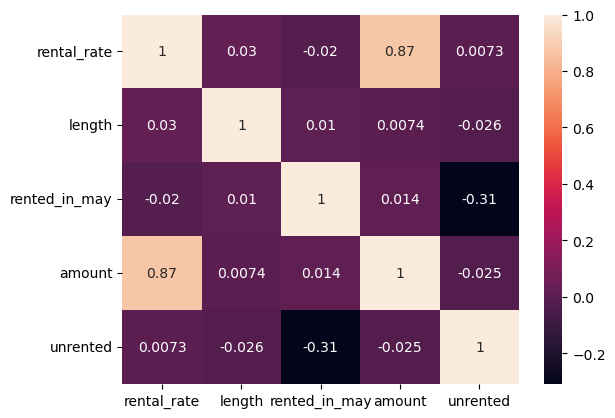

In [16]:
# Heatmap:

sns.heatmap(correlations, annot=True)
plt.show()

In [17]:
# X / y Split:

y = data["rented_in_may"]
X = data.drop("rented_in_may", axis=1)
display(X)

,title,rental_rate,length,rating,special_features,amount,name,unrented
0,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",1.60,Documentary,0
1,ACE GOLDFINGER,4.99,48,G,"Trailers,Deleted Scenes",7.56,Horror,0
2,ADAPTATION HOLES,2.99,50,NC-17,"Trailers,Deleted Scenes",3.16,Documentary,0
3,AFFAIR PREJUDICE,2.99,117,G,"Commentaries,Behind the Scenes",3.99,Horror,0
4,AFRICAN EGG,2.99,130,G,Deleted Scenes,4.32,Family,0
...,...,...,...,...,...,...,...,...
995,YOUNG LANGUAGE,0.99,183,G,"Trailers,Behind the Scenes",0.99,Documentary,0
996,YOUTH KICK,0.99,179,NC-17,"Trailers,Behind the Scenes",2.82,Music,0
997,ZHIVAGO CORE,0.99,105,NC-17,Deleted Scenes,1.66,Horror,0
998,ZOOLANDER FICTION,2.99,101,R,"Trailers,Deleted Scenes",4.34,Children,0


In [18]:
# Train, test, split:

from sklearn.model_selection import train_test_split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('X_train =', X_train.shape)
print('y_train =', y_train.shape)
print('X_test =', X_test.shape)
print('y_test =', y_test.shape)

X_train = (800, 8)
y_train = (800,)
X_test = (200, 8)
y_test = (200,)


In [20]:
X_train.head()

,title,rental_rate,length,rating,special_features,amount,name,unrented
29,ANYTHING SAVANNAH,2.99,82,R,"Trailers,Deleted Scenes,Behind the Scenes",5.21,Horror,0
535,LOVELY JINGLE,2.99,65,PG,"Trailers,Behind the Scenes",4.70,Classics,0
695,PRIDE ALAMO,0.99,114,NC-17,Deleted Scenes,1.18,Animation,0
557,MANNEQUIN WORST,2.99,71,PG-13,"Trailers,Commentaries,Deleted Scenes",4.79,New,0
836,STAGE WORLD,2.99,85,PG,"Commentaries,Behind the Scenes",4.69,Comedy,0


In [21]:
X_test.head()

,title,rental_rate,length,rating,special_features,amount,name,unrented
521,LIFE TWISTED,2.99,137,NC-17,"Commentaries,Deleted Scenes",4.49,Comedy,0
737,ROCKETEER MOTHER,0.99,178,PG-13,"Deleted Scenes,Behind the Scenes",3.54,Foreign,0
740,ROMAN PUNK,0.99,81,NC-17,Trailers,1.24,Music,0
660,PAST SUICIDES,4.99,157,PG-13,"Trailers,Deleted Scenes,Behind the Scenes",5.61,Foreign,0
411,HEAVYWEIGHTS BEAST,4.99,102,G,Deleted Scenes,5.64,Documentary,0


In [22]:
# Defining variables:

X_train_num = X_train.select_dtypes(include = np.number)
X_train_cat = X_train.select_dtypes(include = object)

display(X_train_num)
display(X_train_cat)

,rental_rate,length,amount,unrented
29,2.99,82,5.21,0
535,2.99,65,4.70,0
695,0.99,114,1.18,0
557,2.99,71,4.79,0
836,2.99,85,4.69,0
...,...,...,...,...
106,2.99,63,5.19,0
270,4.99,148,6.56,0
860,4.99,111,7.04,0
435,0.99,122,2.62,0


,title,rating,special_features,name
29,ANYTHING SAVANNAH,R,"Trailers,Deleted Scenes,Behind the Scenes",Horror
535,LOVELY JINGLE,PG,"Trailers,Behind the Scenes",Classics
695,PRIDE ALAMO,NC-17,Deleted Scenes,Animation
557,MANNEQUIN WORST,PG-13,"Trailers,Commentaries,Deleted Scenes",New
836,STAGE WORLD,PG,"Commentaries,Behind the Scenes",Comedy
...,...,...,...,...
106,BUNCH MINDS,G,Behind the Scenes,Drama
270,EASY GLADIATOR,G,"Trailers,Commentaries,Behind the Scenes",Action
860,SUIT WALLS,R,Commentaries,Games
435,HOURS RAGE,NC-17,"Trailers,Deleted Scenes",New


In [23]:
X_test_num = X_test.select_dtypes(include = np.number)
X_test_cat = X_test.select_dtypes(include = object)

display(X_test_num)
display(X_test_cat)

,rental_rate,length,amount,unrented
521,2.99,137,4.49,0
737,0.99,178,3.54,0
740,0.99,81,1.24,0
660,4.99,157,5.61,0
411,4.99,102,5.64,0
...,...,...,...,...
408,4.99,59,6.64,0
332,2.99,126,3.11,0
208,2.99,99,3.76,0
613,4.99,178,5.95,0


,title,rating,special_features,name
521,LIFE TWISTED,NC-17,"Commentaries,Deleted Scenes",Comedy
737,ROCKETEER MOTHER,PG-13,"Deleted Scenes,Behind the Scenes",Foreign
740,ROMAN PUNK,NC-17,Trailers,Music
660,PAST SUICIDES,PG-13,"Trailers,Deleted Scenes,Behind the Scenes",Foreign
411,HEAVYWEIGHTS BEAST,G,Deleted Scenes,Documentary
...,...,...,...,...
408,HEARTBREAKERS BRIGHT,G,"Trailers,Deleted Scenes",Children
332,FREAKY POCUS,R,"Trailers,Behind the Scenes",Music
208,DARKNESS WAR,NC-17,"Deleted Scenes,Behind the Scenes",Drama
613,NAME DETECTIVE,PG-13,"Trailers,Commentaries,Behind the Scenes",Games


In [24]:
# Deciding on Special Features (containing a list):

# On Train:

X_train_cat['special_features'] = X_train_cat['special_features'].str.split(',')
X_train_cat['special_features']

29     [Trailers, Deleted Scenes, Behind the Scenes]
535                    [Trailers, Behind the Scenes]
695                                 [Deleted Scenes]
557         [Trailers, Commentaries, Deleted Scenes]
836                [Commentaries, Behind the Scenes]
                           ...                      
106                              [Behind the Scenes]
270      [Trailers, Commentaries, Behind the Scenes]
860                                   [Commentaries]
435                       [Trailers, Deleted Scenes]
102                   [Commentaries, Deleted Scenes]
Name: special_features, Length: 800, dtype: object

In [25]:
# On Test:

X_test_cat['special_features'] = X_test_cat['special_features'].str.split(',')

In [26]:
# Special features need to be lists to be encoded (first we transform the column and then we encode every cat_var):

# On Train:

X_train_cat = X_train_cat.drop('special_features',1).join(X_train_cat.special_features.str.join('|').str.get_dummies())
X_train_cat.isna().sum()

/var/folders/x2/s0hzmssd661c19sljyg0cl240000gn/T/ipykernel_6151/3113283138.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train_cat = X_train_cat.drop('special_features',1).join(X_train_cat.special_features.str.join('|').str.get_dummies())


title                0
rating               0
name                 0
Behind the Scenes    0
Commentaries         0
Deleted Scenes       0
Trailers             0
dtype: int64

In [27]:
# On Test:

X_test_cat = X_test_cat.drop('special_features',1).join(X_test_cat.special_features.str.join('|').str.get_dummies())
X_test_cat.isna().sum()

/var/folders/x2/s0hzmssd661c19sljyg0cl240000gn/T/ipykernel_6151/868921222.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test_cat = X_test_cat.drop('special_features',1).join(X_test_cat.special_features.str.join('|').str.get_dummies())


title                0
rating               0
name                 0
Behind the Scenes    0
Commentaries         0
Deleted Scenes       0
Trailers             0
dtype: int64

In [28]:
# Encoding the other Cat. variables:

In [29]:
# Rating:

r_train = pd.get_dummies(X_train_cat['rating'], prefix='rating')
r_test = pd.get_dummies(X_test_cat['rating'], prefix='rating')

In [30]:
# Name (category):

c_train = pd.get_dummies(X_train_cat['name'], prefix='genre')
c_test = pd.get_dummies(X_test_cat['name'], prefix='genre')

In [31]:
# Concatenate encoded:

train_encoded = pd.concat([c_train,r_train],axis=1)
test_encoded = pd.concat([c_test,r_test],axis=1)

In [32]:
# Concatenate train and test with econded:

X_train_cat = pd.concat([X_train_cat,train_encoded],axis=1)
X_test_cat = pd.concat([X_test_cat,test_encoded],axis=1)

In [33]:
display(X_train_cat)
display(X_test_cat)

,title,rating,name,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,genre_Children,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
29,ANYTHING SAVANNAH,R,Horror,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
535,LOVELY JINGLE,PG,Classics,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
695,PRIDE ALAMO,NC-17,Animation,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
557,MANNEQUIN WORST,PG-13,New,0,1,1,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
836,STAGE WORLD,PG,Comedy,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,BUNCH MINDS,G,Drama,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
270,EASY GLADIATOR,G,Action,1,1,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
860,SUIT WALLS,R,Games,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
435,HOURS RAGE,NC-17,New,0,0,1,1,0,0,0,...,0,1,0,0,0,0,1,0,0,0


,title,rating,name,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,genre_Children,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
521,LIFE TWISTED,NC-17,Comedy,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
737,ROCKETEER MOTHER,PG-13,Foreign,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
740,ROMAN PUNK,NC-17,Music,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
660,PAST SUICIDES,PG-13,Foreign,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
411,HEAVYWEIGHTS BEAST,G,Documentary,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,HEARTBREAKERS BRIGHT,G,Children,0,0,1,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0
332,FREAKY POCUS,R,Music,1,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
208,DARKNESS WAR,NC-17,Drama,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
613,NAME DETECTIVE,PG-13,Games,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [34]:
# Dropping encoded categories and title (the ones that we did not encode):

# On Train:

X_train_cat = X_train_cat.drop(['rating', 'name', 'title'], axis = 1)
X_train_cat

,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,genre_Children,genre_Classics,genre_Comedy,genre_Documentary,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
29,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
535,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
695,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
557,0,1,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
836,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
270,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
860,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
435,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [35]:
# On Test:

X_test_cat = X_test_cat.drop(['rating', 'name', 'title'], axis = 1)
X_test_cat

,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,genre_Children,genre_Classics,genre_Comedy,genre_Documentary,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
521,0,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
737,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
740,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
660,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
411,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,0,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
332,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
208,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
613,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
# Scaling numerical columns:

In [37]:
# On Train:

transformer = MinMaxScaler().fit(X_train_num)
X_train_norm = transformer.transform(X_train_num)
print(X_train_norm.shape)
X_train_num_scale = pd.DataFrame(X_train_norm, index = X_train_num.index, columns=X_train_num.columns)
X_train_num_scale.head()

(800, 4)


,rental_rate,length,amount,unrented
29,0.5,0.258993,0.549479,0.0
535,0.5,0.136691,0.483073,0.0
695,0.0,0.489209,0.024740,0.0
557,0.5,0.179856,0.494792,0.0
836,0.5,0.280576,0.481771,0.0


In [38]:
# On Test (without fitting X_test / done in X_train):

X_test_norm = transformer.transform(X_test_num)
print(X_test_norm.shape)
X_test_num_scale = pd.DataFrame(X_test_norm, index = X_test_num.index, columns=X_test_num.columns)
X_test_num_scale.head()

(200, 4)


,rental_rate,length,amount,unrented
521,0.5,0.654676,0.455729,0.0
737,0.0,0.949640,0.332031,0.0
740,0.0,0.251799,0.032552,0.0
660,1.0,0.798561,0.601563,0.0
411,1.0,0.402878,0.605469,0.0


In [39]:
# Concatenate numerical and categorical scaled:

In [40]:
X_train = pd.concat([X_train_num_scale,X_train_cat], axis = 1)
X_test = pd.concat([X_test_num_scale,X_test_cat], axis = 1)

display(X_train)
display(X_test)

,rental_rate,length,amount,unrented,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
29,0.5,0.258993,0.549479,0.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
535,0.5,0.136691,0.483073,0.0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
695,0.0,0.489209,0.024740,0.0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
557,0.5,0.179856,0.494792,0.0,0,1,1,1,0,0,...,0,1,0,0,0,0,0,0,1,0
836,0.5,0.280576,0.481771,0.0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.5,0.122302,0.546875,0.0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
270,1.0,0.733813,0.725260,0.0,1,1,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
860,1.0,0.467626,0.787760,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
435,0.0,0.546763,0.212240,0.0,0,0,1,1,0,0,...,0,1,0,0,0,0,1,0,0,0


,rental_rate,length,amount,unrented,Behind the Scenes,Commentaries,Deleted Scenes,Trailers,genre_Action,genre_Animation,...,genre_Music,genre_New,genre_Sci-Fi,genre_Sports,genre_Travel,rating_G,rating_NC-17,rating_PG,rating_PG-13,rating_R
521,0.5,0.654676,0.455729,0.0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
737,0.0,0.949640,0.332031,0.0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
740,0.0,0.251799,0.032552,0.0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
660,1.0,0.798561,0.601563,0.0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,1,0
411,1.0,0.402878,0.605469,0.0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.0,0.093525,0.735677,0.0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,0
332,0.5,0.575540,0.276042,0.0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
208,0.5,0.381295,0.360677,0.0,1,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
613,1.0,0.949640,0.645833,0.0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


5. Create a logistic regression model to predict 'rented_in_may' from the cleaned data.

In [41]:
# Logistic Regression Model:

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression().fit(X_train, y_train)
print('training set score:{:3f}'.format(log_reg.score(X_train,y_train)))
print('test set score:{:3f}'.format(log_reg.score(X_test,y_test)))

training set score:0.727500
test set score:0.720000


In [42]:
# Confusion Matrix:

from sklearn.metrics import confusion_matrix

In [43]:
# Prediction:

prediction = log_reg.predict(X_test)
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [44]:
# Confusion Matrix:

confusion_matrix(y_test,prediction)

array([[  9,  56],
       [  0, 135]])

In [45]:
# Checking the balance of the target:

y.value_counts()  #slightly imbalanced

1    686
0    314
Name: rented_in_may, dtype: int64

In [46]:
confusion_matrix(y_test,prediction)

array([[  9,  56],
       [  0, 135]])

In [47]:
# Imbalanced datasets libraries:

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [48]:
print('accuracy = ', accuracy_score(y_test, prediction))
print('precision = ', precision_score(y_test, prediction))
print('recall = ', recall_score(y_test, prediction))
print('f1 = ', f1_score(y_test, prediction))

accuracy =  0.72
precision =  0.7068062827225131
recall =  1.0
f1 =  0.8282208588957055


In [49]:
# SMOTE for imbalanced data:

from imblearn.over_sampling import SMOTE

In [50]:
# Defining a function for the over sampling:

def over_sampling(training_x, training_y):

    smote = SMOTE(random_state = 100, k_neighbors = 3)
    X_train_scaled_SMOTE, y_train_SMOTE = smote.fit_resample(training_x, training_y)

    return X_train_scaled_SMOTE, y_train_SMOTE    

X_train_SMOTE, y_train_SMOTE = over_sampling(X_train, y_train)
X_test_SMOTE, y_test_SMOTE = over_sampling(X_test,y_test)

In [51]:
# Running logistic regression again on SMOTE data:

logreg2 = LogisticRegression().fit(X_train_SMOTE, y_train_SMOTE)
print('training set score:{:3f}'.format(log_reg.score(X_train_SMOTE,y_train_SMOTE)))
print('test set score:{:3f}'.format(log_reg.score(X_test_SMOTE,y_test_SMOTE)))

training set score:0.561706
test set score:0.588889


In [52]:
# Prediction SMOTE:

prediction_SMOTE = logreg2.predict(X_test_SMOTE)
prediction_SMOTE

array([1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [53]:
# SMOTE: Confusion Matrix:

confusion_matrix(y_test_SMOTE, prediction_SMOTE)

array([[ 81,  54],
       [ 19, 116]])

In [54]:
# SMOTE finding scores using Libraries:

print('accuracy = ', accuracy_score(y_test_SMOTE, prediction_SMOTE))
print('precision = ', precision_score(y_test_SMOTE, prediction_SMOTE))
print('recall = ', recall_score(y_test_SMOTE, prediction_SMOTE))
print('f1 = ', f1_score(y_test_SMOTE, prediction_SMOTE))

accuracy =  0.7296296296296296
precision =  0.6823529411764706
recall =  0.8592592592592593
f1 =  0.760655737704918


In [55]:
# 